In [6]:
%run boilerplate.py

In [7]:
import pandas as pd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
import lightgbm as lgb
import numpy as np
from tqdm import tqdm

In [10]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=DataConversionWarning)
import matplotlib


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import TargetEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold,train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer


In [17]:
import shap

### Reading data

In [11]:
movies_ratings = pd.read_csv(DIR_DATA.joinpath('movies_ratings.csv'))

In [12]:
movies_ratings = movies_ratings.fillna(movies_ratings.median())

In [14]:
tags = pd.read_csv("data/tags.csv")

### General Variables

In [16]:
genre_cols = {'Fantasy', 'Children', 'Animation', 'Comedy', 'Adventure', 'Romance',
       'Drama', 'Action', 'Thriller', 'Crime', 'Horror', 'Mystery', 'Sci-Fi',
       'War', 'Musical', 'Documentary', 'IMAX', 'Western'}
catg_cols = {'primary_lang', 'cast_0', 'cast_1'}
ord_cols = {'release_date_month', 'release_date_dow'}
num_cols = { 'popularity','runtime', 'vote_average', 'vote_count', 'release_date_yr','years_from_release',
        'rating'}

feat_cols = genre_cols.union(num_cols).union(catg_cols).union(ord_cols)

tgt = 'rating'

In [ ]:
usersIds = movies_ratings.userId.unique()
user_movie_watch = {u : movies_ratings.query(f'userId == {u}').movieId.unique() for u in usersIds}

### Features engineering

Median and mode fill NA

In [ ]:
for i in feat_cols:
    if movies_ratings[i].dtype in  {float, int}:
        movies_ratings[i] = movies_ratings[i].fillna(movies_ratings[i].median())
    else:
        movies_ratings[i] = movies_ratings[i].fillna(movies_ratings[i].mode())

Movie tag aggregates

In [18]:
movie_tags_ts_std = tags.groupby('movieId')[['timestamp']].std().add_suffix('_item_ts_std').fillna(0)
movie_tags_ct = tags.groupby('movieId').size().to_frame(name = 'movi_tags_ct').fillna(0)

Movie items aggregates

In [20]:
# Aggregate movie features
agg_movie_grps_df = pd.concat([
        movies_ratings.groupby('movieId').rating.agg([np.min, np.max, np.mean, len, np.std]).add_prefix('item_rating_'),
        movies_ratings.eval('yr_vote_diff = rating_yr - release_date_yr').groupby('movieId').yr_vote_diff.mean().to_frame().add_suffix('_item'),
        movies_ratings.groupby('movieId').timestamp.std().to_frame().add_suffix('_item_std')
], 1).fillna(0)

In [ ]:
# Merging movie tags 
agg_movie_grps_tag_df = agg_movie_grps_df.merge(movie_tags_ct, on = 'movieId', how = 'left').merge(movie_tags_ts_std, on = 'movieId', how = 'left')

In [21]:
full_item_df = movies_ratings.drop(['userId', 'rating', 'tmdbId', 'imdbId','timestamp','rating_yr',],1)
full_item_df = full_item_df.drop_duplicates().set_index('movieId')
tmp = full_item_df.groupby('movieId').size()
assert tmp.loc[lambda x :x>1].empty

Target encoding

In [22]:
# Fit target encoding
lbl_enc = {}
for cols in movies_ratings[feat_cols].select_dtypes(exclude=[float,int, bool]).columns:
    feat_cols.remove(cols)
    lbl_enc[cols] = TargetEncoder()
    movies_ratings[f"enc_{cols}"] = lbl_enc[cols].fit_transform(movies_ratings[[cols]], movies_ratings[[tgt]])
    num_cols.add(f"enc_{cols}")
    feat_cols.add(f"enc_{cols}")
    print(f"Removing {cols} and creating enc_{cols} ")


Removing cast_1 and creating enc_cast_1 
Removing primary_lang and creating enc_primary_lang 
Removing cast_0 and creating enc_cast_0 


In [23]:
# Perform Target encoding
for col, enc in lbl_enc.items():
    print(col)
    full_item_df[f"enc_{col}"] = lbl_enc[col].transform(full_item_df[[col]])

cast_1
primary_lang
cast_0


In [24]:
full_item_df['rating_yr'] = 2023

In [25]:
# Check feat_cols difference with full_item
assert len(feat_cols.difference(full_item_df.filter(feat_cols).columns).difference({tgt})) == 0

Create item df for inference evaluation

In [29]:
full_item_df = full_item_df.merge(agg_movie_grps_tag_df, on='movieId', how = 'left').fillna(0)

In [30]:
item_df = full_item_df.filter(feat_cols)

Generating user attributes

In [33]:
def genre_mean(x: pd.DataFrame):
    """Taking mean only when genre = 1

    Args:
        x (_type_): _description_

    Returns:
        _type_: _description_
    """
    res = {}
    for g in genre_cols:
        mask = x[g]==1
        res[g]  = x.loc[mask, tgt].mean()
    return pd.Series(res)
    
def wt_avg(x, cols, tgt):
    """Apply wt avg for each cols based on tgt column"""
    res = {}
    for c in cols:
        res[c] = np.average(x[c].values, weights=x[tgt].values)
    return pd.Series(res)

def genre_cum_norm(x):
    """Using timestamp apply Cumulative normalization by row for genere cols"""
    x = x.set_index(['userId','timestamp']).groupby('timestamp').apply(lambda x: x[list(genre_cols)].mul(x['rating'], axis=0))
    cumsum = (x.groupby('timestamp')[list(genre_cols)].sum()).cumsum()
    return cumsum.div(cumsum.sum(axis=1), axis=0)


In [34]:
def genre_rating_diff(x, genre_rating):
    """ Rating diff between user and global for each genre"""
    genre_dist = x[list(genre_cols)].sum()
    genre_dist = genre_dist/genre_dist.sum()
    # display(genre_dist)
    res = {}
    for g,r in genre_rating.items():
        mask = x[g]==1
        if mask.any():
            res[g] =  (x.loc[mask,'rating'].mean()) - r
        else:
            res[g] = 0
    return pd.Series(res)
        
genre_rating = {g: movies_ratings.loc[movies_ratings[g] == 1, 'rating'].mean() for g in genre_cols}

In [35]:
def genre_watched_diff(x, genre_watched):
    """Compare Scaled movie watch vs Global movie watch by Genre"""
    genre_dist = x[list(genre_cols)].sum()
    genre_dist = genre_dist/genre_dist.sum()
    return (genre_dist / genre_watched).apply(np.exp)
    # # display(genre_dist)
    # res = {}
    # for g,r in genre_rating.items():
    #     mask = x[g]==1
    #     if mask.any():
    #         res[g] =  (x.loc[mask,'rating'].mean()) - r
    #     else:
    #         res[g] = 0
    # return pd.Series(res)
        
genre_watched = movies_ratings[list(genre_cols)].sum()/movies_ratings[list(genre_cols)].sum().sum()


In [36]:
# Aggregate user features
def user_features(df):
    usr_grp = df.groupby('userId')
    usr_grp_genre_mean = usr_grp.apply(lambda x: genre_rating_diff(x, genre_rating)).add_suffix('_user_genre_rating_diff').fillna(0)
    usr_grp_genre_dist = usr_grp.apply(genre_watched_diff, genre_watched).add_suffix('_user_genre_dist').fillna(0)

    return pd.concat([
        usr_grp_genre_mean,
        usr_grp_genre_dist,
], axis=1)


In [37]:
user_gen_feat = user_features(movies_ratings).reset_index()

In [38]:
user_ts_genre_profile = movies_ratings.groupby('userId').apply(genre_cum_norm).add_suffix('_user_cum_norm').reset_index()

In [39]:
# No Na columns
assert (user_gen_feat.describe().T['count'] == user_gen_feat.shape[0]).all()
assert (user_ts_genre_profile.userId.nunique() == user_gen_feat.shape[0])

In [40]:
feat_cols = feat_cols.union(set(user_gen_feat.columns[1:])).union(set((user_ts_genre_profile.columns[2:])))
num_cols = num_cols.union(set(user_gen_feat.columns[1:])).union(set((user_ts_genre_profile.columns[2:])))

In [41]:
# User_gen_feat same number as unique userId
assert movies_ratings.userId.nunique() == user_gen_feat.shape[0]

Merge user info with movie_rating

In [42]:
tmp = movies_ratings.merge(user_gen_feat, on='userId', validate="m:1")
assert tmp.shape[0] == movies_ratings.shape[0]
movies_ratings = tmp.copy()
del tmp

In [43]:
tmp = movies_ratings.merge(user_ts_genre_profile, on=['userId', 'timestamp'], validate="m:1")
assert tmp.shape[0] == movies_ratings.shape[0]
movies_ratings = tmp.copy()
del tmp

In [44]:
if user_ts_genre_profile.columns[-1] not in user_gen_feat.columns:
    last_user_ts_genre_profile = user_ts_genre_profile.groupby('userId').last().drop('timestamp',1)
    user_gen_feat = user_gen_feat.merge(last_user_ts_genre_profile, on = 'userId', validate="1:1")
    user_gen_feat = user_gen_feat.set_index('userId')

### Training and Test data generation 

Stratified Split by User

In [45]:
train_df, test_df = ut.split_train_val_test(movies_ratings[feat_cols.union({'userId', 'movieId'})], val_frac = 0.1, stratify=movies_ratings['userId'])

train_size =  90752 
val_size =  10084 


In [46]:
train_df['has_rated'] = 1
test_df['has_rated'] = 1
# test_df = test_df.set_index('userId')

Generate negative sample

In [47]:
NEG_TRAIN_SAMPLES = 4

In [51]:
u_res = {}
user_cols = list(user_gen_feat.columns)
for u in tqdm(train_df.userId.unique()):
    user_train_df = train_df[train_df.userId == u]
    u_s = user_train_df.shape[0]
    item_sample_df = full_item_df.loc[~full_item_df.index.isin(user_movie_watch[u])].sample(NEG_TRAIN_SAMPLES  * (u_s), replace=True).reset_index()
    item_sample_df['rating'] = 0
    res = []
    for _, (i, user_row) in enumerate(user_train_df.iterrows()):
        pos_df = user_row.to_frame().T.set_index('movieId')
        neg_df = pos_df[user_cols].merge(item_sample_df.iloc[_ * NEG_TRAIN_SAMPLES: (_+1) *NEG_TRAIN_SAMPLES], how = 'cross').set_index('movieId')

        res.append(neg_df[feat_cols].eval("has_rated = 0"))
        res.append(pos_df[feat_cols].eval("has_rated = 1"))
    u_res[u] = pd.concat(res)


100%|██████████| 610/610 [23:21<00:00,  2.30s/it]  


In [52]:
train_neg_df = pd.concat(u_res, names=['userId'])
train_neg_df.reset_index().to_csv('data/train_neg_df.csv')

In [54]:
NEG_TEST_SAMPLES = 19

In [55]:
u_res = {}
user_cols = list(user_gen_feat.columns)
for u in tqdm(test_df.userId.unique()):
# for u in tqdm(train_neg_df.index.get_level_values(0).unique()):
    user_train_df = test_df[test_df.userId == u]
    u_s = user_train_df.shape[0]
    movie_neg_test = full_item_df.index.difference(user_movie_watch[u]).difference(train_neg_df.loc[u].index)
    item_sample_df = full_item_df.loc[movie_neg_test].sample(NEG_TEST_SAMPLES  * (u_s), replace=True).reset_index()
    item_sample_df['rating'] = 0
    res = []
    
    for _, (i, user_row) in enumerate(user_train_df.iterrows()):
        pos_df = user_row.to_frame().T.set_index('movieId')
        neg_df = pos_df[user_cols].merge(item_sample_df.iloc[_ * NEG_TEST_SAMPLES: (_+1) * NEG_TEST_SAMPLES], how = 'cross').set_index('movieId')

        res.append(neg_df[feat_cols].eval("has_rated = 0"))
        res.append(pos_df[feat_cols].eval("has_rated = 1"))
    u_res[u] = pd.concat(res)





  0%|          | 0/610 [00:00<?, ?it/s]

100%|██████████| 610/610 [02:38<00:00,  3.84it/s]


In [56]:
test_neg_df = pd.concat(u_res, names = ['userId'])
test_neg_df.reset_index().to_csv('data/test_neg_df.csv')

In [48]:
train_neg_df = pd.read_csv('data/train_neg_df.csv')

In [49]:
train_neg_df = train_neg_df.set_index(['userId', 'movieId']).drop('Unnamed: 0',1)

In [50]:
train_neg_df.head()

Horror_user_genre_dist  Documentary  Mystery  \
userId movieId                                                 
68     33124.0                3.071399          0.0      0.0   
       5077.0                 3.071399          0.0      0.0   
       2872.0                 3.071399          0.0      0.0   
       6816.0                 3.071399          0.0      0.0   
       3753.0                 3.071399          0.0      0.0   

                Crime_user_genre_dist  enc_primary_lang_user_wt_avg  \
userId movieId                                                        
68     33124.0               2.413155                      3.494951   
       5077.0                2.413155                      3.494951   
       2872.0                2.413155                      3.494951   
       6816.0                2.413155                      3.494951   
       3753.0                2.413155                      3.494951   

                Action_user_genre_rating_diff  popularity_user_std  \
userId movieId                                                       
68     33124.0                      -0.106734            22.836839   
       5077.0                       -0.106734            22.836839   
       2872.0                       -0.106734            22.836839   
       6816.0                       -0.106734            22.836839   
       3753.0                       -0.106734            22.836839   

                vote_average  release_date_yr_user_wt_avg  \
userId movieId                                              
68     33124.0         7.043                  1998.077187   
       5077.0          6.000                  1998.077187   
       2872.0          7.000                  1998.077187   
       6816.0          6.800                  1998.077187   
       3753.0          7.171                  1998.077187   

                years_from_release_user_std  Fantasy_user_genre_rating_diff  \
userId movieId                                                                
68     33124.0                    12.473315                        -0.20022   
       5077.0                     12.473315                        -0.20022   
       2872.0                     12.473315                        -0.20022   
       6816.0                     12.473315                        -0.20022   
       3753.0                     12.473315                        -0.20022   

                release_date_dow  Comedy_user_genre_dist  \
userId movieId                                             
68     33124.0               6.0                2.932802   
       5077.0                4.0                2.932802   
       2872.0                4.0                2.932802   
       6816.0                4.0                2.932802   
       3753.0                2.0                2.932802   

                Drama_user_genre_dist  Animation_user_cum_norm  \
userId movieId                                                   
68     33124.0               2.525403                 0.021346   
       5077.0                2.525403                 0.021346   
       2872.0                2.525403                 0.021346   
       6816.0                2.525403                 0.021346   
       3753.0                2.525403                 0.021346   

                Fantasy_user_cum_norm  Children_user_genre_dist  \
userId movieId                                                    
68     33124.0               0.057745                  2.516888   
       5077.0                0.057745                  2.516888   
       2872.0                0.057745                  2.516888   
       6816.0                0.057745                  2.516888   
       3753.0                0.057745                  2.516888   

                Crime_user_cum_norm  Children_user_genre_rating_diff  Comedy  \
userId movieId                                                                 
68     33124.0             0.054735                        -0.305479     0.0   
  

In [51]:
test_neg_df = pd.read_csv('data/test_neg_df.csv')
test_neg_df = test_neg_df.set_index(['userId', 'movieId']).drop('Unnamed: 0',1)

In [52]:
test_neg_df.head()

Horror_user_genre_dist  Documentary  Mystery  \
userId movieId                                                  
465    7070.0                  2.399156          0.0      0.0   
       2897.0                  2.399156          0.0      0.0   
       170945.0                2.399156          0.0      1.0   
       175569.0                2.399156          0.0      1.0   
       104925.0                2.399156          0.0      0.0   

                 Crime_user_genre_dist  enc_primary_lang_user_wt_avg  \
userId movieId                                                         
465    7070.0                 5.081588                      3.525664   
       2897.0                 5.081588                      3.525664   
       170945.0               5.081588                      3.525664   
       175569.0               5.081588                      3.525664   
       104925.0               5.081588                      3.525664   

                 Action_user_genre_rating_diff  popularity_user_std  \
userId movieId                                                        
465    7070.0                         0.392925            16.229942   
       2897.0                         0.392925            16.229942   
       170945.0                       0.392925            16.229942   
       175569.0                       0.392925            16.229942   
       104925.0                       0.392925            16.229942   

                 vote_average  release_date_yr_user_wt_avg  \
userId movieId                                               
465    7070.0           7.383                  1981.476987   
       2897.0           7.216                  1981.476987   
       170945.0         5.839                  1981.476987   
       175569.0         7.431                  1981.476987   
       104925.0         6.361                  1981.476987   

                 years_from_release_user_std  Fantasy_user_genre_rating_diff  \
userId movieId                                                                 
465    7070.0                      15.657051                        0.508999   
       2897.0                      15.657051                        0.508999   
       170945.0                    15.657051                        0.508999   
       175569.0                    15.657051                        0.508999   
       104925.0                    15.657051                        0.508999   

                 release_date_dow  Comedy_user_genre_dist  \
userId movieId                                              
465    7070.0                 3.0                1.358441   
       2897.0                 4.0                1.358441   
       170945.0               4.0                1.358441   
       175569.0               3.0                1.358441   
       104925.0               4.0                1.358441   

                 Drama_user_genre_dist  Animation_user_cum_norm  \
userId movieId                                                    
465    7070.0                 2.901533                      0.0   
       2897.0                 2.901533                      0.0   
       170945.0               2.901533                      0.0   
       175569.0               2.901533                      0.0   
       104925.0               2.901533                      0.0   

                 Fantasy_user_cum_norm  Children_user_genre_dist  \
userId movieId                                                     
465    7070.0                 0.043011                  1.090478   
       2897.0                 0.043011                  1.090478   
       170945.0               0.043011                  1.090478   
       175569.0               0.043011                  1.090478   
       104925.0               0.043011                  1.090478   

                 Crime_user_cum_norm  Children_user_genre_rating_diff  Comedy  \
userId movieId                                                                  
465    7070.0            

In [53]:
train_sample_wt =((train_neg_df['rating'].astype(int)*2 - 1) * train_neg_df['has_rated']) + 1
test_sample_wt =(((test_neg_df['rating'].astype(int) - 1) * test_neg_df['has_rated']) + 1)

In [54]:
feat_cols = feat_cols -{'userId', 'timestamp','rating', 'enc_primary_lang'}

Merging movie aggregates 

In [55]:
train_neg_df =(train_neg_df.reset_index().merge(agg_movie_grps_tag_df, on='movieId')
 .set_index(['userId', 'movieId'])
).fillna(0)

test_neg_df = (test_neg_df.reset_index().merge(agg_movie_grps_tag_df, on='movieId')
 .set_index(['userId', 'movieId'])
).fillna(0)
feat_cols = feat_cols.union(agg_movie_grps_tag_df.columns)

In [57]:
X_train, y_train = train_neg_df[feat_cols], train_neg_df[['has_rated']]

In [58]:
X_test, y_test = test_neg_df[feat_cols], test_neg_df[['has_rated']]

In [59]:
# Making sure the y_test has same number of has_rated cases
assert y_test.loc[3]['has_rated'].sum() == test_neg_df.loc[3].has_rated.sum()

In [60]:

from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, f_classif
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import f1_score, precision_recall_fscore_support


In [63]:
X_train.shape, X_test.shape

((453760, 91), (201680, 91))

In [64]:
# Same number of cols in train and test
assert X_train.columns.symmetric_difference(X_test.columns).empty

In [542]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [65]:
# Checking list of cols
len(feat_cols), feat_cols

(91,
 {'Action',
  'Action_user_cum_norm',
  'Action_user_genre_dist',
  'Action_user_genre_rating_diff',
  'Adventure',
  'Adventure_user_cum_norm',
  'Adventure_user_genre_dist',
  'Adventure_user_genre_rating_diff',
  'Animation',
  'Animation_user_cum_norm',
  'Animation_user_genre_dist',
  'Animation_user_genre_rating_diff',
  'Children',
  'Children_user_cum_norm',
  'Children_user_genre_dist',
  'Children_user_genre_rating_diff',
  'Comedy',
  'Comedy_user_cum_norm',
  'Comedy_user_genre_dist',
  'Comedy_user_genre_rating_diff',
  'Crime',
  'Crime_user_cum_norm',
  'Crime_user_genre_dist',
  'Crime_user_genre_rating_diff',
  'Documentary',
  'Documentary_user_cum_norm',
  'Documentary_user_genre_dist',
  'Documentary_user_genre_rating_diff',
  'Drama',
  'Drama_user_cum_norm',
  'Drama_user_genre_dist',
  'Drama_user_genre_rating_diff',
  'Fantasy',
  'Fantasy_user_cum_norm',
  'Fantasy_user_genre_dist',
  'Fantasy_user_genre_rating_diff',
  'Horror',
  'Horror_user_cum_norm',


### Building model


Training model for each user

In [ ]:
user_models = {}
best_model_param = {}

for u in tqdm(train_neg_df.index.get_level_values(0).unique()):
    user_models[u] =  Pipeline(
    [
        ('p', 
                   Pipeline([   
                       ('poly', PolynomialFeatures(include_bias=False,interaction_only=True)),
                       ('vif', VarianceThreshold()),
                        ('ss', StandardScaler()),
                       ])), 
                   ('reg', lgb.LGBMClassifier(objective="binary",verbose=-1, boosting_type='gbdt',
    metric="auc",  class_weight= "balanced", learning_rate=0.1,
     n_estimators = 400,  reg_lambda=0.2, min_child_samples=5, sub_feature=0.8, n_jobs=-1
    ))
    ])
    user_models[u].fit(X_train.loc[u],
        y_train.loc[u, 'has_rated']
        # ,reg__sample_weight = train_sample_wt.loc[u]
    )
    
    # For hyper parameter tuning
    # param_grid = {
    #     # 'reg__learning_rate': np.logspace(-2, -1, 4),
    #     'reg__n_estimators': np.logspace(1.25, 2.6, 4).astype(int),
    #     'reg__max_depth' : [ 3, 5, 7],
    #     'reg__min_data_in_leaf': np.logspace(.6 ,1.5, 4).astype(int),
    #     'reg__sub_feature': [0.5, .95],
    # }
    # grid = RandomizedSearchCV(user_models[u], param_grid, cv=5, n_iter=35, n_jobs=-1, scoring='roc_auc')
    
   
    # grid.fit(X_train.loc[u],
    #     y_train.loc[u, 'has_rated'],
    # )
    # best_model_param[u] = grid.best_params_
    # user_models[u] = grid




Understanding feature importances

In [551]:
res_feat_imp = {}
for u,m in user_models.items():
    res_feat_imp[u] = pd.Series(m.named_steps['reg'].feature_importances_, m.named_steps['p'].get_feature_names_out())
res_feat_imp_agg = pd.concat(res_feat_imp).reset_index(name='feat_imp').groupby('level_1').feat_imp.mean().sort_values()

In [553]:
# Understanding Feature importance stats of patterns of features
for pat in ['_amax','timestamp_item_std','tag','_user_genre_rating_diff','_user_genre_dist', '_user_cum_norm']:
    print(pat)
    display(res_feat_imp_agg[res_feat_imp_agg.index.str.contains(pat)].describe())

_amax


count    91.000000
mean      2.754988
std       4.375258
min       0.000000
25%       0.002466
50%       0.480328
75%       4.887124
max      23.027869
Name: feat_imp, dtype: float64

timestamp_item_std


count    91.000000
mean      4.529385
std       5.055350
min       0.000000
25%       0.135861
50%       2.111475
75%       8.176230
max      23.434426
Name: feat_imp, dtype: float64

tag


count    91.000000
mean      1.100809
std       1.268962
min       0.000000
25%       0.012933
50%       0.408451
75%       2.051957
max       5.702703
Name: feat_imp, dtype: float64

_user_genre_rating_diff


count    990.000000
mean       0.125061
std        0.413906
min        0.000000
25%        0.001639
50%        0.017134
75%        0.091381
max        8.238487
Name: feat_imp, dtype: float64

_user_genre_dist


count    990.000000
mean       0.044138
std        0.324687
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        7.280328
Name: feat_imp, dtype: float64

_user_cum_norm


count    1485.000000
mean        2.471076
std         3.278275
min         0.000000
25%         0.013752
50%         0.693662
75%         4.029703
max        23.174056
Name: feat_imp, dtype: float64

In [554]:
# top features importance 
res_feat_imp_agg.tail(50).to_frame()

,feat_imp
level_1,
Crime_user_cum_norm item_rating_len,13.285240
vote_average,13.411475
Drama_user_cum_norm vote_average,13.532787
enc_cast_0 years_from_release,13.624590
item_rating_len popularity,13.873770
item_rating_amin runtime,13.880328
enc_cast_0,13.895082
Adventure_user_cum_norm item_rating_len,13.917492
release_date_month timestamp_item_std,13.921311


### Evaluating Precision, recall and F1 on test data

In [ ]:
res = {}
for u in tqdm(user_models):
    y_test.loc[u, 'pred'] = user_models[u].predict(X_test.loc[u])
    res[u] = pd.DataFrame(
        precision_recall_fscore_support(y_test.loc[u, 'has_rated'], y_test.loc[u, 'pred'], zero_division = np.nan)
        , index = ['prec', 'recall', 'f1', 'support']).stack().to_frame().T
    # (ConfusionMatrixDisplay(confusion_matrix(y_test.loc[u], y_test.loc[u, 'pred'])).plot())
test_res = pd.concat(res).fillna(0)
test_res.columns =['_'.join(map(str, i)) for i in  test_res.columns]


In [558]:
#  interaction
np.average(test_res['prec_1'], weights=test_res['support_1']), np.average(test_res['recall_1'], weights=test_res['support_1']),np.average(test_res['f1_1'], weights=test_res['support_1'])

(0.47786824178333, 0.8208052360174534, 0.5984826286616498)

### Evaluation on Inference data with all movies

In [624]:

res = {}
# Movies rated by user in training data
train_user_movie_watch = train_neg_df.query('has_rated==1').reset_index('movieId').groupby('userId')['movieId'].apply(set).to_dict()
for u in tqdm( [470] or user_models):
    # All movies except movies rated by user in training
    user_infer_movies = full_item_df.loc[full_item_df.index.difference(train_user_movie_watch[u])]
    
    # Generating user and item cross data
    X_test_user = (user_gen_feat.loc[[u]]
                   .merge(user_infer_movies.reset_index(), how = 'cross')
    ).set_index('movieId')[X_train.columns]
    # Generating y_test as 0 for all cases except for movies rated by user in test data for evaluation
    y_test_user =pd.DataFrame([0] * X_test_user.shape[0], index = X_test_user.index, columns=['has_rated'])
    tmp = y_test.loc[u]
    y_test_user.loc[tmp.index, 'has_rated'] = tmp['has_rated']

    # Using model for inferencing
    y_test_user['pred'] = user_models[u].predict_proba(X_test_user.fillna(0))[:, 1]
    # Getting top 20 predictions
    res[u] = y_test_user.sort_values('pred').tail(20).has_rated.sum()


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


### Comparison with Baseline on inference

In [606]:
simple_res = {}
# Get popular movies based on rating by user and weighted by number of rating by users
simple_model = (movies_ratings.groupby('movieId')
                .apply(lambda x: np.mean(x.rating)) * np.log(movies_ratings.groupby('movieId').size()) # type: ignore
                ).sort_values(ascending=False)

In [608]:

for u in tqdm(user_models):
    simple_pred = simple_model.index.difference(train_user_movie_watch[u])[:20]
    simple_res[u] = len(simple_pred.intersection(y_test.loc[u].query('has_rated==1').index))

100%|██████████| 610/610 [00:02<00:00, 215.91it/s]


In [609]:
top_20_pred = pd.concat([pd.Series(res, name='num_relevant_top20'),
                         test_neg_df.groupby('userId').has_rated.sum(),
                         pd.Series(simple_res, name='simple_pred')
                         ],1).sort_values('num_relevant_top20')

In [628]:
top_20_pred[['num_relevant_top20', 'simple_pred']].rename(columns = {'num_relevant_top20': 'CG model'}).mean()

CG model       1.973770
simple_pred    0.245902
dtype: float64

In [564]:
top_20_pred['atleast_5_relevant'] = (top_20_pred.num_relevant_top20).clip(upper=5)

Text(0.5, 1.0, 'Histogram of Top 5 relevant items presented to users')

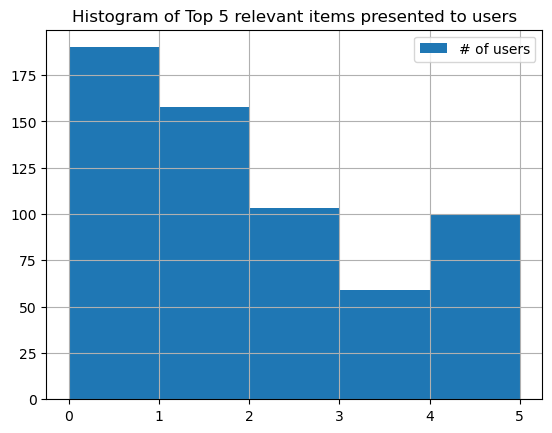

In [566]:
ax = top_20_pred.atleast_5_relevant.rename('# of users').hist(bins=5, legend=True)
ax.set_title("Histogram of Top 5 relevant items presented to users")

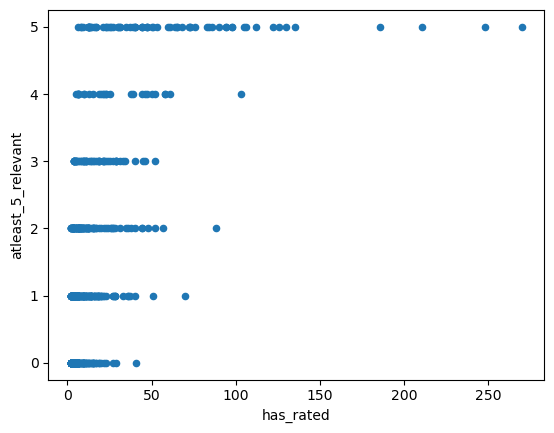

In [319]:
ax = top_20_pred.plot(y = 'atleast_5_relevant',  x= 'has_rated', kind='scatter')
# ax.set_title("")

### Understanding Recommendation of Inference with Shap

In [574]:
train_feat = X_train.columns

In [575]:
def get_recommend(user_id):

    X_test_user = (user_gen_feat.loc[[user_id]]
                   .merge(full_item_df.loc[~full_item_df.index.isin(train_user_movie_watch[user_id])].reset_index(), how = 'cross')
    )
    movieId = X_test_user['movieId']
    # for c in catg_cols:
    #     X_test_user[c] = X_test_user[c].astype('category')
    pred = user_models[user_id].predict_proba(X_test_user[train_feat])[:, 1]
    # X_test_user[X_train.columns] = l_reg.named_steps['s'].transform(X_test_user[X_train.columns])
    X_test_user['pred'] = pred
    return X_test_user.set_index(movieId).sort_values('pred',ascending = False).head()
    
    

In [576]:
rec_user = get_recommend(10)


In [582]:
import matplotlib.pylab as plt

#### For given user get shap force plot

In [583]:
uid = 474
l_reg = user_models[uid]
tree = l_reg.named_steps['reg']
explainer = shap.TreeExplainer(tree)
rec_user = get_recommend(uid)
feat_cols_poly = l_reg.named_steps['p'].get_feature_names_out()

if isinstance(l_reg, Pipeline):
    X_test_poly = l_reg.named_steps['p'].transform(rec_user[train_feat])
    
    X_test_poly = pd.DataFrame(X_test_poly, columns = feat_cols_poly, index = rec_user.index)
    rec_user = pd.concat([rec_user[rec_user.columns[~rec_user.columns.isin(train_feat)]],
           X_test_poly
], axis=1)

shap_values = explainer.shap_values(rec_user[feat_cols_poly])

rec_user_display = rec_user.round(1).copy()
for col, enc in lbl_enc.items():
    rec_user_display[f'enc_{col}'] = rec_user_display[col]



LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [587]:
test_df.query(f'userId == {uid} and movieId == 7584')['has_rated']

44185    1
Name: has_rated, dtype: int64

,Documentary_user_genre_rating_diff,Mystery_user_genre_rating_diff,Sci-Fi_user_genre_rating_diff,Children_user_genre_rating_diff,Musical_user_genre_rating_diff,Action_user_genre_rating_diff,Crime_user_genre_rating_diff,IMAX_user_genre_rating_diff,Adventure_user_genre_rating_diff,Fantasy_user_genre_rating_diff,Comedy_user_genre_rating_diff,Drama_user_genre_rating_diff,Thriller_user_genre_rating_diff,Western_user_genre_rating_diff,Animation_user_genre_rating_diff,War_user_genre_rating_diff,Horror_user_genre_rating_diff,Romance_user_genre_rating_diff,Documentary_user_genre_dist,Mystery_user_genre_dist,Sci-Fi_user_genre_dist,Children_user_genre_dist,Musical_user_genre_dist,Action_user_genre_dist,Crime_user_genre_dist,IMAX_user_genre_dist,Adventure_user_genre_dist,Fantasy_user_genre_dist,Comedy_user_genre_dist,Drama_user_genre_dist,Thriller_user_genre_dist,Western_user_genre_dist,Animation_user_genre_dist,War_user_genre_dist,Horror_user_genre_dist,Romance_user_genre_dist,runtime_user_wt_avg,popularity_user_wt_avg,vote_count_user_wt_avg,vote_average_user_wt_avg,enc_cast_1_user_wt_avg,years_from_release_user_wt_avg,enc_primary_lang_user_wt_avg,enc_cast_0_user_wt_avg,release_date_yr_user_wt_avg,vote_count_user_std,vote_average_user_std,enc_primary_lang_user_std,runtime_user_std,popularity_user_std,enc_cast_1_user_std,years_from_release_user_std,rating_user_std,enc_cast_0_user_std,release_date_yr_user_std,Documentary_user_cum_norm,Mystery_user_cum_norm,Sci-Fi_user_cum_norm,Children_user_cum_norm,Musical_user_cum_norm,Action_user_cum_norm,Crime_user_cum_norm,IMAX_user_cum_norm,Adventure_user_cum_norm,Fantasy_user_cum_norm,Comedy_user_cum_norm,Drama_user_cum_norm,Thriller_user_cum_norm,Western_user_cum_norm,Animation_user_cum_norm,War_user_cum_norm,Horror_user_cum_norm,Romance_user_cum_norm
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
474,-0.104237,-0.149467,-0.035191,-0.141638,-0.168156,-0.222321,-0.172697,0.322841,-0.1052,-0.205789,-0.202666,-0.106312,-0.019494,-0.313104,-0.142437,-0.343692,-0.156253,-0.028079,85.549038,3.055943,1.666438,2.263674,6.609138,1.537583,2.338536,1.270201,1.891193,2.013268,3.152899,5.111512,2.158496,4.26465,1.949591,3.881413,2.279232,5.160317,112.062038,20.213871,2075.21298,7.027151,3.582664,40.88617,3.510174,3.5985,1982.53231,3475.391465,0.692268,0.10369,22.892104,17.554574,0.46203,21.370385,0.830847,0.433529,21.364037,0.021467,0.031997,0.032278,0.026373,0.028435,0.045558,0.052933,0.004187,0.056151,0.029154,0.152923,0.260226,0.075774,0.009812,0.017436,0.024466,0.019967,0.110865


,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,enc_cast_0,enc_cast_1,item_rating_amax,item_rating_amin,item_rating_len,item_rating_mean,item_rating_std,popularity,release_date_dow,release_date_month,release_date_yr,runtime,timestamp_item_std,vote_average,vote_count,years_from_release,yr_vote_diff_item
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7584,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,3.618312,4.07952,4.0,4.0,2,4.0,0.0,11.691,3.0,2.0,1942.0,114.0,3.158622e+07,6.9,127.0,81.895525,64.0


Woman of the Year (1942) 7584


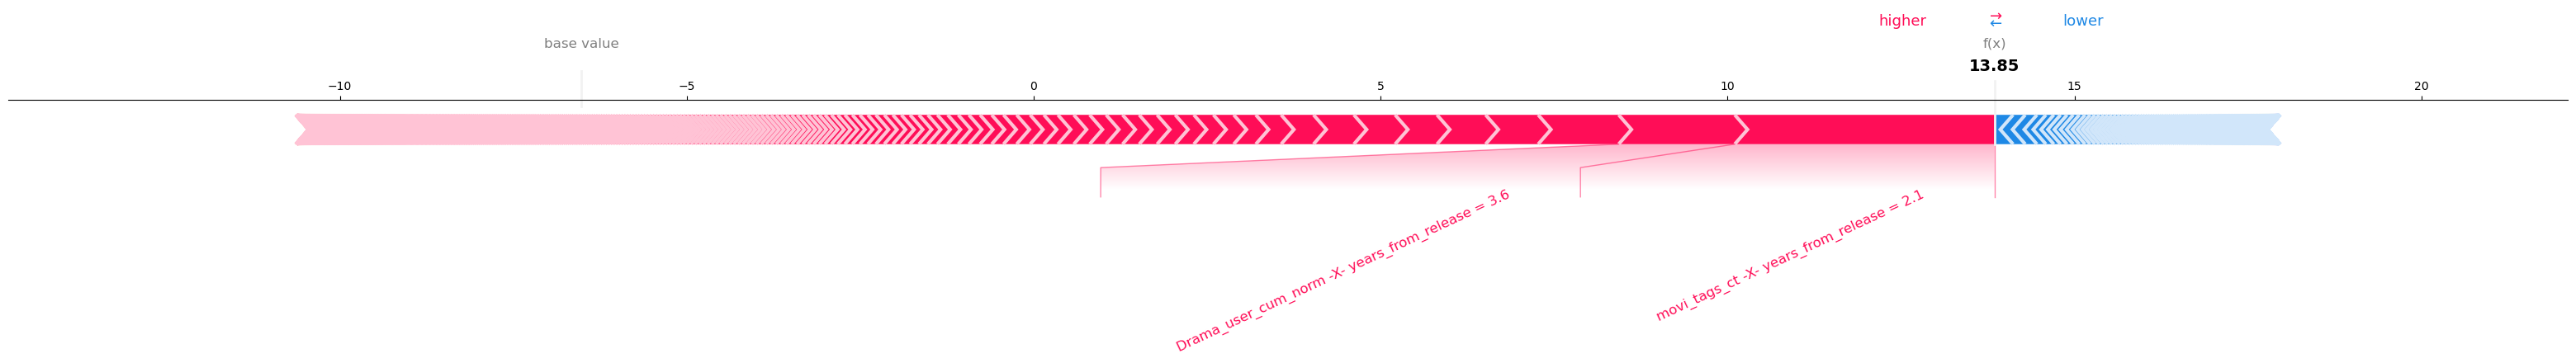

,Documentary_user_genre_rating_diff,Mystery_user_genre_rating_diff,Sci-Fi_user_genre_rating_diff,Children_user_genre_rating_diff,Musical_user_genre_rating_diff,Action_user_genre_rating_diff,Crime_user_genre_rating_diff,IMAX_user_genre_rating_diff,Adventure_user_genre_rating_diff,Fantasy_user_genre_rating_diff,Comedy_user_genre_rating_diff,Drama_user_genre_rating_diff,Thriller_user_genre_rating_diff,Western_user_genre_rating_diff,Animation_user_genre_rating_diff,War_user_genre_rating_diff,Horror_user_genre_rating_diff,Romance_user_genre_rating_diff,Documentary_user_genre_dist,Mystery_user_genre_dist,Sci-Fi_user_genre_dist,Children_user_genre_dist,Musical_user_genre_dist,Action_user_genre_dist,Crime_user_genre_dist,IMAX_user_genre_dist,Adventure_user_genre_dist,Fantasy_user_genre_dist,Comedy_user_genre_dist,Drama_user_genre_dist,Thriller_user_genre_dist,Western_user_genre_dist,Animation_user_genre_dist,War_user_genre_dist,Horror_user_genre_dist,Romance_user_genre_dist,runtime_user_wt_avg,popularity_user_wt_avg,vote_count_user_wt_avg,vote_average_user_wt_avg,enc_cast_1_user_wt_avg,years_from_release_user_wt_avg,enc_primary_lang_user_wt_avg,enc_cast_0_user_wt_avg,release_date_yr_user_wt_avg,vote_count_user_std,vote_average_user_std,enc_primary_lang_user_std,runtime_user_std,popularity_user_std,enc_cast_1_user_std,years_from_release_user_std,rating_user_std,enc_cast_0_user_std,release_date_yr_user_std,Documentary_user_cum_norm,Mystery_user_cum_norm,Sci-Fi_user_cum_norm,Children_user_cum_norm,Musical_user_cum_norm,Action_user_cum_norm,Crime_user_cum_norm,IMAX_user_cum_norm,Adventure_user_cum_norm,Fantasy_user_cum_norm,Comedy_user_cum_norm,Drama_user_cum_norm,Thriller_user_cum_norm,Western_user_cum_norm,Animation_user_cum_norm,War_user_cum_norm,Horror_user_cum_norm,Romance_user_cum_norm
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
474,-0.104237,-0.149467,-0.035191,-0.141638,-0.168156,-0.222321,-0.172697,0.322841,-0.1052,-0.205789,-0.202666,-0.106312,-0.019494,-0.313104,-0.142437,-0.343692,-0.156253,-0.028079,85.549038,3.055943,1.666438,2.263674,6.609138,1.537583,2.338536,1.270201,1.891193,2.013268,3.152899,5.111512,2.158496,4.26465,1.949591,3.881413,2.279232,5.160317,112.062038,20.213871,2075.21298,7.027151,3.582664,40.88617,3.510174,3.5985,1982.53231,3475.391465,0.692268,0.10369,22.892104,17.554574,0.46203,21.370385,0.830847,0.433529,21.364037,0.021467,0.031997,0.032278,0.026373,0.028435,0.045558,0.052933,0.004187,0.056151,0.029154,0.152923,0.260226,0.075774,0.009812,0.017436,0.024466,0.019967,0.110865


,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,enc_cast_0,enc_cast_1,item_rating_amax,item_rating_amin,item_rating_len,item_rating_mean,item_rating_std,popularity,release_date_dow,release_date_month,release_date_yr,runtime,timestamp_item_std,vote_average,vote_count,years_from_release,yr_vote_diff_item
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1225,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4.179629,4.179629,5.0,2.0,76,4.184211,0.752073,29.453,2.0,9.0,1984.0,161.0,1.903993e+08,8.036,3872.0,39.274527,22.539474


Amadeus (1984) 1225


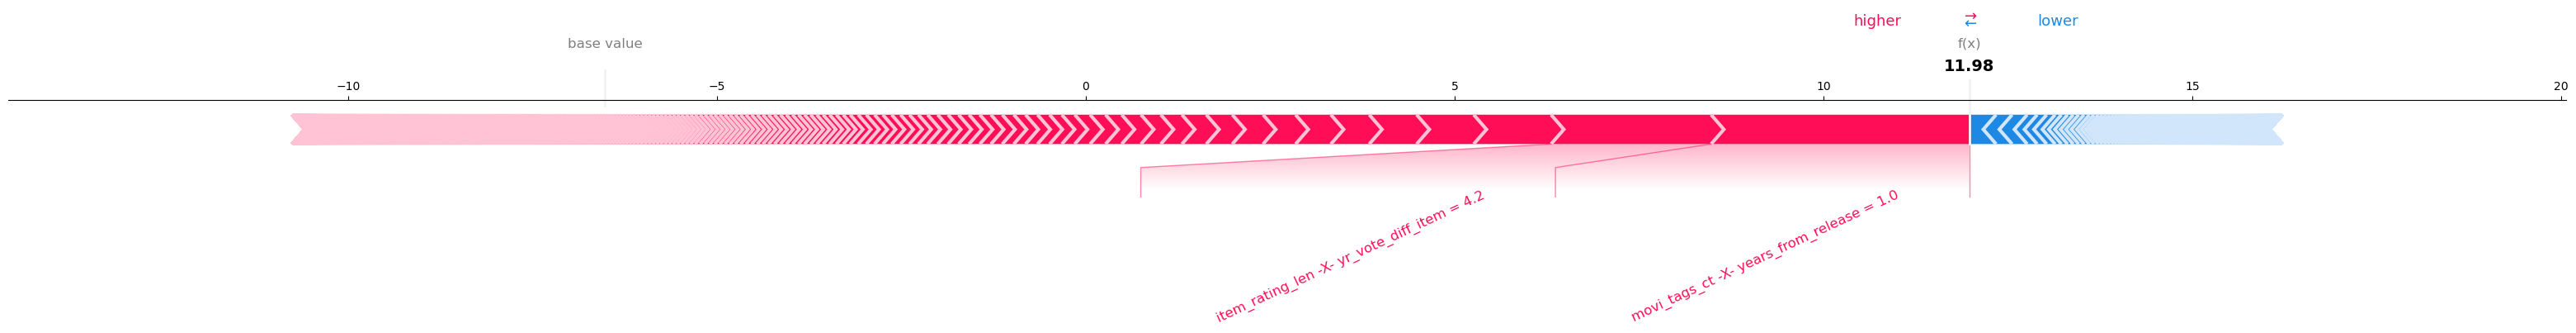

,Documentary_user_genre_rating_diff,Mystery_user_genre_rating_diff,Sci-Fi_user_genre_rating_diff,Children_user_genre_rating_diff,Musical_user_genre_rating_diff,Action_user_genre_rating_diff,Crime_user_genre_rating_diff,IMAX_user_genre_rating_diff,Adventure_user_genre_rating_diff,Fantasy_user_genre_rating_diff,Comedy_user_genre_rating_diff,Drama_user_genre_rating_diff,Thriller_user_genre_rating_diff,Western_user_genre_rating_diff,Animation_user_genre_rating_diff,War_user_genre_rating_diff,Horror_user_genre_rating_diff,Romance_user_genre_rating_diff,Documentary_user_genre_dist,Mystery_user_genre_dist,Sci-Fi_user_genre_dist,Children_user_genre_dist,Musical_user_genre_dist,Action_user_genre_dist,Crime_user_genre_dist,IMAX_user_genre_dist,Adventure_user_genre_dist,Fantasy_user_genre_dist,Comedy_user_genre_dist,Drama_user_genre_dist,Thriller_user_genre_dist,Western_user_genre_dist,Animation_user_genre_dist,War_user_genre_dist,Horror_user_genre_dist,Romance_user_genre_dist,runtime_user_wt_avg,popularity_user_wt_avg,vote_count_user_wt_avg,vote_average_user_wt_avg,enc_cast_1_user_wt_avg,years_from_release_user_wt_avg,enc_primary_lang_user_wt_avg,enc_cast_0_user_wt_avg,release_date_yr_user_wt_avg,vote_count_user_std,vote_average_user_std,enc_primary_lang_user_std,runtime_user_std,popularity_user_std,enc_cast_1_user_std,years_from_release_user_std,rating_user_std,enc_cast_0_user_std,release_date_yr_user_std,Documentary_user_cum_norm,Mystery_user_cum_norm,Sci-Fi_user_cum_norm,Children_user_cum_norm,Musical_user_cum_norm,Action_user_cum_norm,Crime_user_cum_norm,IMAX_user_cum_norm,Adventure_user_cum_norm,Fantasy_user_cum_norm,Comedy_user_cum_norm,Drama_user_cum_norm,Thriller_user_cum_norm,Western_user_cum_norm,Animation_user_cum_norm,War_user_cum_norm,Horror_user_cum_norm,Romance_user_cum_norm
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
474,-0.104237,-0.149467,-0.035191,-0.141638,-0.168156,-0.222321,-0.172697,0.322841,-0.1052,-0.205789,-0.202666,-0.106312,-0.019494,-0.313104,-0.142437,-0.343692,-0.156253,-0.028079,85.549038,3.055943,1.666438,2.263674,6.609138,1.537583,2.338536,1.270201,1.891193,2.013268,3.152899,5.111512,2.158496,4.26465,1.949591,3.881413,2.279232,5.160317,112.062038,20.213871,2075.21298,7.027151,3.582664,40.88617,3.510174,3.5985,1982.53231,3475.391465,0.692268,0.10369,22.892104,17.554574,0.46203,21.370385,0.830847,0.433529,21.364037,0.021467,0.031997,0.032278,0.026373,0.028435,0.045558,0.052933,0.004187,0.056151,0.029154,0.152923,0.260226,0.075774,0.009812,0.017436,0.024466,0.019967,0.110865


,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,enc_cast_0,enc_cast_1,item_rating_amax,item_rating_amin,item_rating_len,item_rating_mean,item_rating_std,popularity,release_date_dow,release_date_month,release_date_yr,runtime,timestamp_item_std,vote_average,vote_count,years_from_release,yr_vote_diff_item
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1283,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,3.844265,4.198924,5.0,3.0,19,4.210526,0.751217,19.249,0.0,6.0,1952.0,85.0,1.921884e+08,7.694,1291.0,71.55445,52.947368


High Noon (1952) 1283


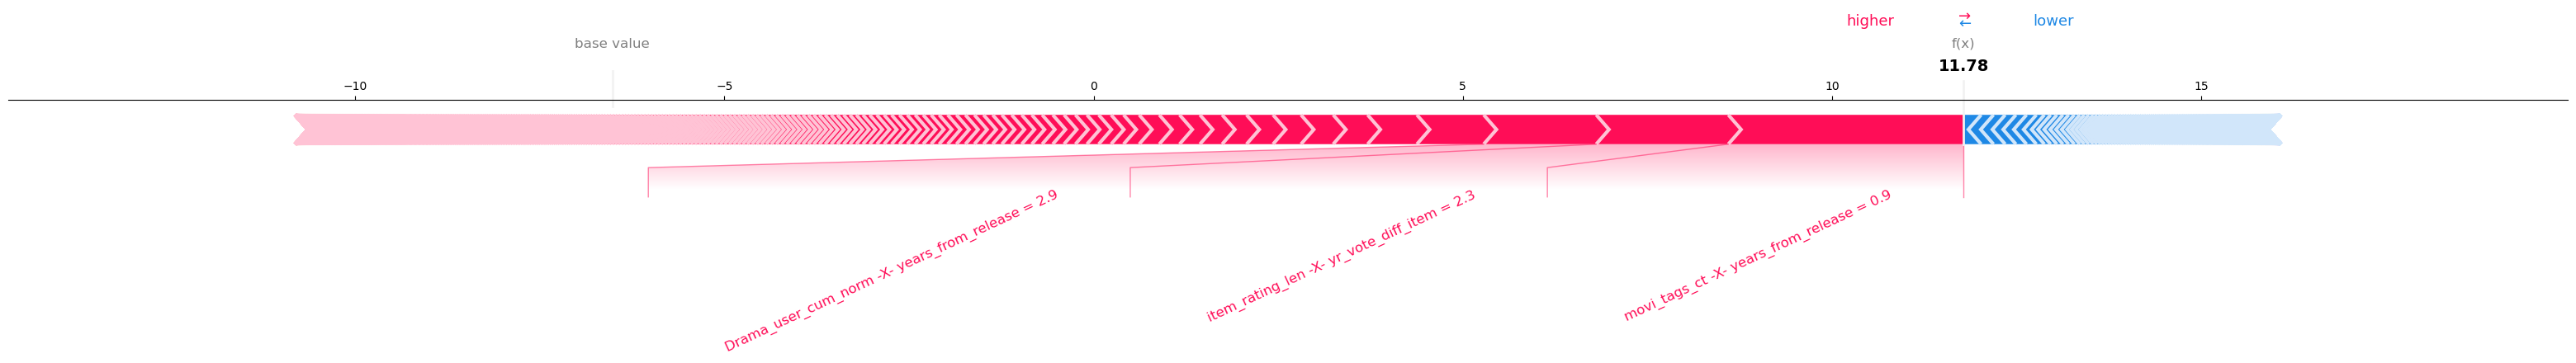

,Documentary_user_genre_rating_diff,Mystery_user_genre_rating_diff,Sci-Fi_user_genre_rating_diff,Children_user_genre_rating_diff,Musical_user_genre_rating_diff,Action_user_genre_rating_diff,Crime_user_genre_rating_diff,IMAX_user_genre_rating_diff,Adventure_user_genre_rating_diff,Fantasy_user_genre_rating_diff,Comedy_user_genre_rating_diff,Drama_user_genre_rating_diff,Thriller_user_genre_rating_diff,Western_user_genre_rating_diff,Animation_user_genre_rating_diff,War_user_genre_rating_diff,Horror_user_genre_rating_diff,Romance_user_genre_rating_diff,Documentary_user_genre_dist,Mystery_user_genre_dist,Sci-Fi_user_genre_dist,Children_user_genre_dist,Musical_user_genre_dist,Action_user_genre_dist,Crime_user_genre_dist,IMAX_user_genre_dist,Adventure_user_genre_dist,Fantasy_user_genre_dist,Comedy_user_genre_dist,Drama_user_genre_dist,Thriller_user_genre_dist,Western_user_genre_dist,Animation_user_genre_dist,War_user_genre_dist,Horror_user_genre_dist,Romance_user_genre_dist,runtime_user_wt_avg,popularity_user_wt_avg,vote_count_user_wt_avg,vote_average_user_wt_avg,enc_cast_1_user_wt_avg,years_from_release_user_wt_avg,enc_primary_lang_user_wt_avg,enc_cast_0_user_wt_avg,release_date_yr_user_wt_avg,vote_count_user_std,vote_average_user_std,enc_primary_lang_user_std,runtime_user_std,popularity_user_std,enc_cast_1_user_std,years_from_release_user_std,rating_user_std,enc_cast_0_user_std,release_date_yr_user_std,Documentary_user_cum_norm,Mystery_user_cum_norm,Sci-Fi_user_cum_norm,Children_user_cum_norm,Musical_user_cum_norm,Action_user_cum_norm,Crime_user_cum_norm,IMAX_user_cum_norm,Adventure_user_cum_norm,Fantasy_user_cum_norm,Comedy_user_cum_norm,Drama_user_cum_norm,Thriller_user_cum_norm,Western_user_cum_norm,Animation_user_cum_norm,War_user_cum_norm,Horror_user_cum_norm,Romance_user_cum_norm
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
474,-0.104237,-0.149467,-0.035191,-0.141638,-0.168156,-0.222321,-0.172697,0.322841,-0.1052,-0.205789,-0.202666,-0.106312,-0.019494,-0.313104,-0.142437,-0.343692,-0.156253,-0.028079,85.549038,3.055943,1.666438,2.263674,6.609138,1.537583,2.338536,1.270201,1.891193,2.013268,3.152899,5.111512,2.158496,4.26465,1.949591,3.881413,2.279232,5.160317,112.062038,20.213871,2075.21298,7.027151,3.582664,40.88617,3.510174,3.5985,1982.53231,3475.391465,0.692268,0.10369,22.892104,17.554574,0.46203,21.370385,0.830847,0.433529,21.364037,0.021467,0.031997,0.032278,0.026373,0.028435,0.045558,0.052933,0.004187,0.056151,0.029154,0.152923,0.260226,0.075774,0.009812,0.017436,0.024466,0.019967,0.110865


,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,enc_cast_0,enc_cast_1,item_rating_amax,item_rating_amin,item_rating_len,item_rating_mean,item_rating_std,popularity,release_date_dow,release_date_month,release_date_yr,runtime,timestamp_item_std,vote_average,vote_count,years_from_release,yr_vote_diff_item
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
912,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,4.109768,4.207146,5.0,0.5,100,4.24,0.900281,31.415,4.0,1.0,1943.0,102.0,1.970493e+08,8.166,4979.0,80.953685,63.68


Casablanca (1942) 912


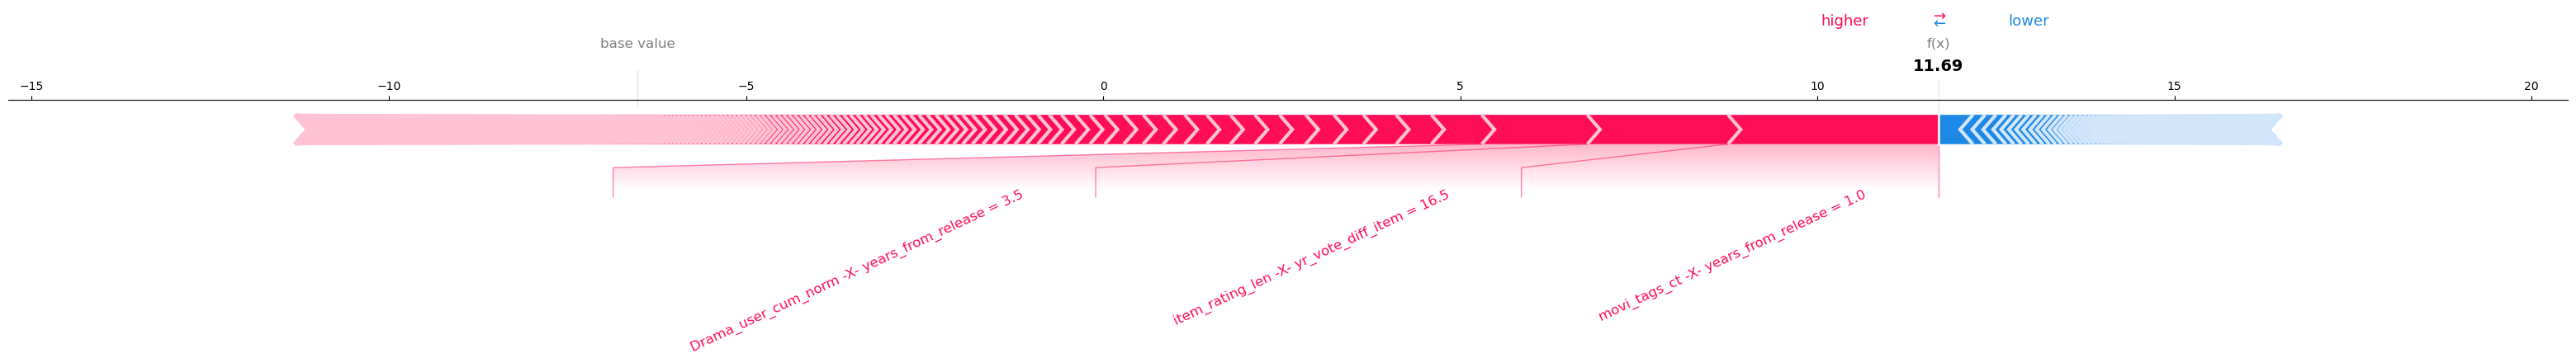

,Documentary_user_genre_rating_diff,Mystery_user_genre_rating_diff,Sci-Fi_user_genre_rating_diff,Children_user_genre_rating_diff,Musical_user_genre_rating_diff,Action_user_genre_rating_diff,Crime_user_genre_rating_diff,IMAX_user_genre_rating_diff,Adventure_user_genre_rating_diff,Fantasy_user_genre_rating_diff,Comedy_user_genre_rating_diff,Drama_user_genre_rating_diff,Thriller_user_genre_rating_diff,Western_user_genre_rating_diff,Animation_user_genre_rating_diff,War_user_genre_rating_diff,Horror_user_genre_rating_diff,Romance_user_genre_rating_diff,Documentary_user_genre_dist,Mystery_user_genre_dist,Sci-Fi_user_genre_dist,Children_user_genre_dist,Musical_user_genre_dist,Action_user_genre_dist,Crime_user_genre_dist,IMAX_user_genre_dist,Adventure_user_genre_dist,Fantasy_user_genre_dist,Comedy_user_genre_dist,Drama_user_genre_dist,Thriller_user_genre_dist,Western_user_genre_dist,Animation_user_genre_dist,War_user_genre_dist,Horror_user_genre_dist,Romance_user_genre_dist,runtime_user_wt_avg,popularity_user_wt_avg,vote_count_user_wt_avg,vote_average_user_wt_avg,enc_cast_1_user_wt_avg,years_from_release_user_wt_avg,enc_primary_lang_user_wt_avg,enc_cast_0_user_wt_avg,release_date_yr_user_wt_avg,vote_count_user_std,vote_average_user_std,enc_primary_lang_user_std,runtime_user_std,popularity_user_std,enc_cast_1_user_std,years_from_release_user_std,rating_user_std,enc_cast_0_user_std,release_date_yr_user_std,Documentary_user_cum_norm,Mystery_user_cum_norm,Sci-Fi_user_cum_norm,Children_user_cum_norm,Musical_user_cum_norm,Action_user_cum_norm,Crime_user_cum_norm,IMAX_user_cum_norm,Adventure_user_cum_norm,Fantasy_user_cum_norm,Comedy_user_cum_norm,Drama_user_cum_norm,Thriller_user_cum_norm,Western_user_cum_norm,Animation_user_cum_norm,War_user_cum_norm,Horror_user_cum_norm,Romance_user_cum_norm
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
474,-0.104237,-0.149467,-0.035191,-0.141638,-0.168156,-0.222321,-0.172697,0.322841,-0.1052,-0.205789,-0.202666,-0.106312,-0.019494,-0.313104,-0.142437,-0.343692,-0.156253,-0.028079,85.549038,3.055943,1.666438,2.263674,6.609138,1.537583,2.338536,1.270201,1.891193,2.013268,3.152899,5.111512,2.158496,4.26465,1.949591,3.881413,2.279232,5.160317,112.062038,20.213871,2075.21298,7.027151,3.582664,40.88617,3.510174,3.5985,1982.53231,3475.391465,0.692268,0.10369,22.892104,17.554574,0.46203,21.370385,0.830847,0.433529,21.364037,0.021467,0.031997,0.032278,0.026373,0.028435,0.045558,0.052933,0.004187,0.056151,0.029154,0.152923,0.260226,0.075774,0.009812,0.017436,0.024466,0.019967,0.110865


,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,enc_cast_0,enc_cast_1,item_rating_amax,item_rating_amin,item_rating_len,item_rating_mean,item_rating_std,popularity,release_date_dow,release_date_month,release_date_yr,runtime,timestamp_item_std,vote_average,vote_count,years_from_release,yr_vote_diff_item
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2291,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,3.568117,3.331555,5.0,2.0,80,3.7,0.634454,53.829,4.0,12.0,1990.0,105.0,1.823881e+08,7.718,12131.0,33.059478,18.725


Edward Scissorhands (1990) 2291


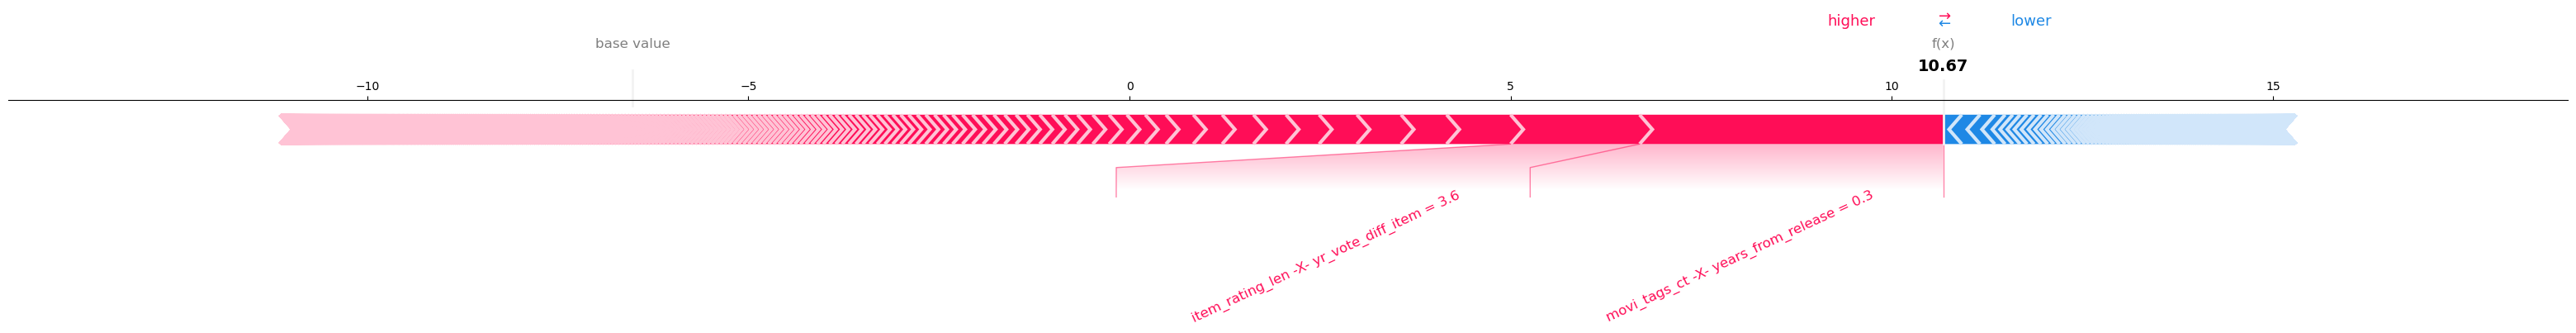

In [585]:
shap.initjs()
for r in range(5):
    # r = 4
    movie = rec_user_display.iloc[r, :]
    display(user_gen_feat.loc[[uid]])
    display(item_df.loc[[movie.movieId]])
    print(movie.title, movie['movieId'])
    # plt.figure(figsize=(40,6))
    shap.force_plot(explainer.expected_value[1], shap_values[1][r, :], movie[feat_cols_poly],feature_names = pd.Index(feat_cols_poly).str.replace(' ', ' -X- '), matplotlib=matplotlib
                    , text_rotation=25, figsize=[40,3], contribution_threshold=0.05)

### Storing pickled objects

In [588]:
import joblib,pickle

In [589]:
joblib.dump(user_models, "./results/best_model/pipeline_user_clf_3.joblib")

['./results/best_model/pipeline_user_clf_3.joblib']

In [314]:
joblib.dump(l_reg, "./results/best_model/pipeline_lgb.joblib")

['./results/best_model/pipeline_lgb.joblib']

In [591]:
user_gen_feat.to_pickle('./results/best_model/user_gen_feat.pkl')
full_item_df.to_pickle('./results/best_model/full_item_df.pkl')


In [592]:
with open('./results/best_model/train_feat.pkl', 'wb') as f:
    pickle.dump(train_feat, f)

In [593]:
with open('./results/best_model/train_user_movie_watch.pkl', 'wb') as f:
    pickle.dump(train_user_movie_watch, f)

In [594]:
y_test.query('has_rated==1').to_pickle('./results/best_model/rating_y_test.pkl')

### Reproduce for docker

In [697]:
def get_recommend2(user_id, l_reg,l_rank, full_item_df, train_feat, rank_train_feat, user_gen_feat, train_user_movie_watch):

    X_test_user = (user_gen_feat.loc[[user_id]]
                   .merge(full_item_df.loc[~full_item_df.index.isin(train_user_movie_watch[user_id])].reset_index(), how = 'cross')
    )
    movieId = X_test_user['movieId']
    # for c in catg_cols:
    #     X_test_user[c] = X_test_user[c].astype('category')
    pred = l_reg.predict_proba(X_test_user[train_feat])[:, 1]
    # X_test_user[X_train.columns] = l_reg.named_steps['s'].transform(X_test_user[X_train.columns])
    X_test_user['pred'] = pred
    X_test_rank = X_test_user.set_index(movieId).sort_values('pred',ascending = False).head(20)
    X_test_rank = X_test_rank.drop('movieId',1).merge(_rating_y_test.drop('pred',1).loc[user_id], on='movieId', how = 'left')
    display(X_test_rank[['title', 'pred', 'has_rated']])
    X_test_rank['timestamp_item_ts_std'] = X_test_rank['movi__ts_std']
    print(X_test_rank[rank_train_feat].shape)
    X_test_rank['rank_pred'] = l_rank.predict(X_test_rank[rank_train_feat]) * X_test_rank['pred']
    
    display(X_test_rank[['title', 'pred', 'rank_pred', 'has_rated']].sort_values('rank_pred',ascending = False))
    return X_test_rank.sort_values('rank_pred',ascending = False).head()
    
    

In [629]:
_model = joblib.load('./results/best_model/pipeline_user_clf_3.joblib')
_rank = joblib.load('./results/best_model/pipeline_rank_poly_V3.joblib')
_user_gen_feat= pd.read_pickle('./results/best_model/user_gen_feat.pkl')
_full_item_df= pd.read_pickle('./results/best_model/full_item_df.pkl')

_train_feat = pickle.load(open('./results/best_model/train_feat.pkl', 'rb') )
_rank_train_feat = pickle.load(open('./results/best_model/rank_train_feat.pkl', 'rb') )

_user_movie_watch = pickle.load(open('./results/best_model/user_movie_watch.pkl', 'rb') )
_train_user_movie_watch = pickle.load(open('./results/best_model/train_user_movie_watch.pkl', 'rb'))
_rating_y_test = pd.read_pickle('./results/best_model/rating_y_test.pkl')


In [699]:
uid = 1

In [700]:
l_reg = _model[uid]
l_rank = _rank[uid]
tree = l_reg.named_steps['reg']

In [701]:
rec_user = get_recommend2(uid, l_reg,l_rank, _full_item_df, _train_feat,_rank_train_feat, _user_gen_feat, _train_user_movie_watch)

,title,pred,has_rated
movieId,,,
10,GoldenEye (1995),0.999977,NaN
589,Terminator 2: Judgment Day (1991),0.999974,NaN
1374,Star Trek II: The Wrath of Khan (1982),0.999968,NaN
380,True Lies (1994),0.999957,NaN
3635,"Spy Who Loved Me, The (1977)",0.999942,NaN
2989,For Your Eyes Only (1981),0.999938,NaN
1527,"Fifth Element, The (1997)",0.999924,NaN
1036,Die Hard (1988),0.999923,NaN
1610,"Hunt for Red October, The (1990)",0.999917,NaN


(20, 91)


,title,pred,rank_pred,has_rated
movieId,,,,
589,Terminator 2: Judgment Day (1991),0.999974,7.069389,NaN
2012,Back to the Future Part III (1990),0.999881,6.042621,1.0
1527,"Fifth Element, The (1997)",0.999924,5.996342,NaN
1036,Die Hard (1988),0.999923,5.690016,NaN
1377,Batman Returns (1992),0.999851,4.578972,1.0
1374,Star Trek II: The Wrath of Khan (1982),0.999968,4.541668,NaN
1610,"Hunt for Red October, The (1990)",0.999917,4.246956,NaN
1275,Highlander (1986),0.999906,4.048708,1.0
380,True Lies (1994),0.999957,3.965199,NaN


In [671]:
explainer = shap.TreeExplainer(tree)

feat_cols_poly = l_reg.named_steps['p'].get_feature_names_out()

X_test_poly = l_reg.named_steps['p'].transform(rec_user[_train_feat])

X_test_poly = pd.DataFrame(X_test_poly, columns = feat_cols_poly, index = rec_user.index)
rec_user = pd.concat([rec_user[rec_user.columns[~rec_user.columns.isin(_train_feat)]],
    X_test_poly
], axis=1)

shap_values = explainer.shap_values(rec_user[feat_cols_poly])

rec_user_display = rec_user.round(1).copy()
for col, enc in lbl_enc.items():
    rec_user_display[f'enc_{col}'] = rec_user_display[col]


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [644]:
movie[['title', 'pred']]

title    Edward Scissorhands (1990)
pred                            1.0
Name: 2291, dtype: object

,Documentary_user_genre_rating_diff,Mystery_user_genre_rating_diff,Sci-Fi_user_genre_rating_diff,Children_user_genre_rating_diff,Musical_user_genre_rating_diff,Action_user_genre_rating_diff,Crime_user_genre_rating_diff,IMAX_user_genre_rating_diff,Adventure_user_genre_rating_diff,Fantasy_user_genre_rating_diff,Comedy_user_genre_rating_diff,Drama_user_genre_rating_diff,Thriller_user_genre_rating_diff,Western_user_genre_rating_diff,Animation_user_genre_rating_diff,War_user_genre_rating_diff,Horror_user_genre_rating_diff,Romance_user_genre_rating_diff,Documentary_user_genre_dist,Mystery_user_genre_dist,Sci-Fi_user_genre_dist,Children_user_genre_dist,Musical_user_genre_dist,Action_user_genre_dist,Crime_user_genre_dist,IMAX_user_genre_dist,Adventure_user_genre_dist,Fantasy_user_genre_dist,Comedy_user_genre_dist,Drama_user_genre_dist,Thriller_user_genre_dist,Western_user_genre_dist,Animation_user_genre_dist,War_user_genre_dist,Horror_user_genre_dist,Romance_user_genre_dist,runtime_user_wt_avg,popularity_user_wt_avg,vote_count_user_wt_avg,vote_average_user_wt_avg,enc_cast_1_user_wt_avg,years_from_release_user_wt_avg,enc_primary_lang_user_wt_avg,enc_cast_0_user_wt_avg,release_date_yr_user_wt_avg,vote_count_user_std,vote_average_user_std,enc_primary_lang_user_std,runtime_user_std,popularity_user_std,enc_cast_1_user_std,years_from_release_user_std,rating_user_std,enc_cast_0_user_std,release_date_yr_user_std,Documentary_user_cum_norm,Mystery_user_cum_norm,Sci-Fi_user_cum_norm,Children_user_cum_norm,Musical_user_cum_norm,Action_user_cum_norm,Crime_user_cum_norm,IMAX_user_cum_norm,Adventure_user_cum_norm,Fantasy_user_cum_norm,Comedy_user_cum_norm,Drama_user_cum_norm,Thriller_user_cum_norm,Western_user_cum_norm,Animation_user_cum_norm,War_user_cum_norm,Horror_user_cum_norm,Romance_user_cum_norm
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
474,-0.104237,-0.149467,-0.035191,-0.141638,-0.168156,-0.222321,-0.172697,0.322841,-0.1052,-0.205789,-0.202666,-0.106312,-0.019494,-0.313104,-0.142437,-0.343692,-0.156253,-0.028079,85.549038,3.055943,1.666438,2.263674,6.609138,1.537583,2.338536,1.270201,1.891193,2.013268,3.152899,5.111512,2.158496,4.26465,1.949591,3.881413,2.279232,5.160317,112.062038,20.213871,2075.21298,7.027151,3.582664,40.88617,3.510174,3.5985,1982.53231,3475.391465,0.692268,0.10369,22.892104,17.554574,0.46203,21.370385,0.830847,0.433529,21.364037,0.021467,0.031997,0.032278,0.026373,0.028435,0.045558,0.052933,0.004187,0.056151,0.029154,0.152923,0.260226,0.075774,0.009812,0.017436,0.024466,0.019967,0.110865


Woman of the Year (1942) 7584


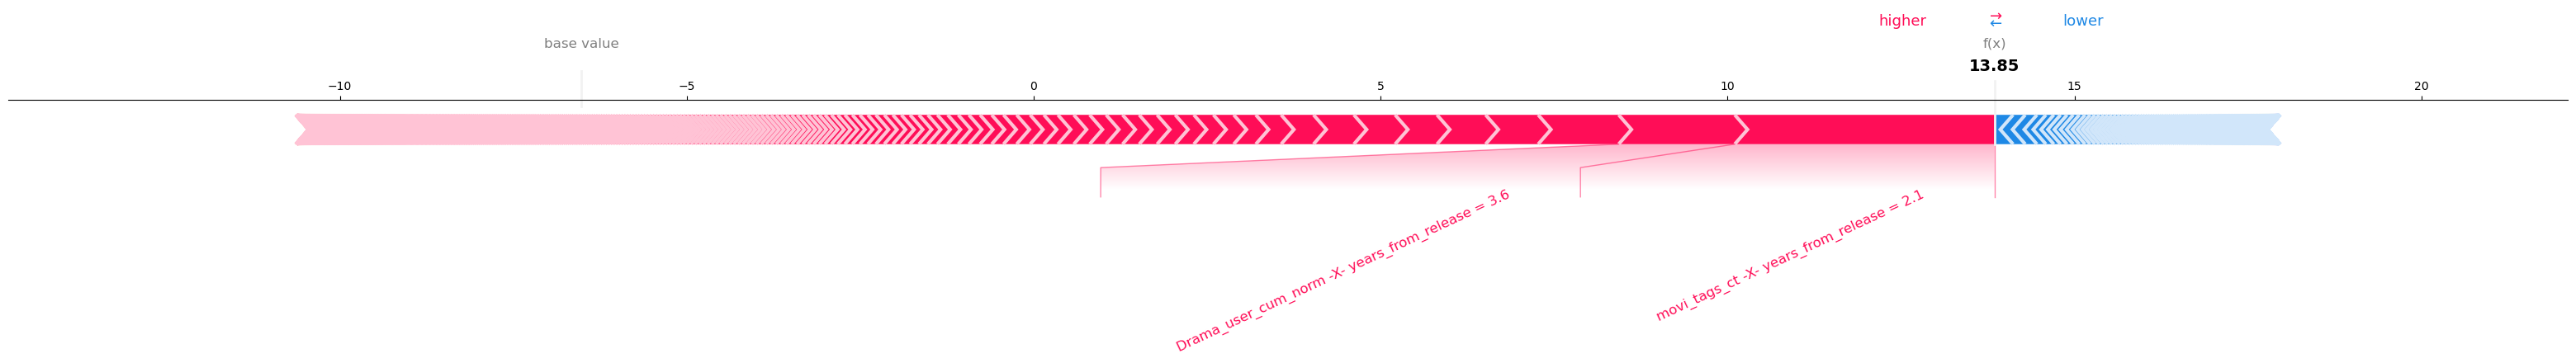

,Documentary_user_genre_rating_diff,Mystery_user_genre_rating_diff,Sci-Fi_user_genre_rating_diff,Children_user_genre_rating_diff,Musical_user_genre_rating_diff,Action_user_genre_rating_diff,Crime_user_genre_rating_diff,IMAX_user_genre_rating_diff,Adventure_user_genre_rating_diff,Fantasy_user_genre_rating_diff,Comedy_user_genre_rating_diff,Drama_user_genre_rating_diff,Thriller_user_genre_rating_diff,Western_user_genre_rating_diff,Animation_user_genre_rating_diff,War_user_genre_rating_diff,Horror_user_genre_rating_diff,Romance_user_genre_rating_diff,Documentary_user_genre_dist,Mystery_user_genre_dist,Sci-Fi_user_genre_dist,Children_user_genre_dist,Musical_user_genre_dist,Action_user_genre_dist,Crime_user_genre_dist,IMAX_user_genre_dist,Adventure_user_genre_dist,Fantasy_user_genre_dist,Comedy_user_genre_dist,Drama_user_genre_dist,Thriller_user_genre_dist,Western_user_genre_dist,Animation_user_genre_dist,War_user_genre_dist,Horror_user_genre_dist,Romance_user_genre_dist,runtime_user_wt_avg,popularity_user_wt_avg,vote_count_user_wt_avg,vote_average_user_wt_avg,enc_cast_1_user_wt_avg,years_from_release_user_wt_avg,enc_primary_lang_user_wt_avg,enc_cast_0_user_wt_avg,release_date_yr_user_wt_avg,vote_count_user_std,vote_average_user_std,enc_primary_lang_user_std,runtime_user_std,popularity_user_std,enc_cast_1_user_std,years_from_release_user_std,rating_user_std,enc_cast_0_user_std,release_date_yr_user_std,Documentary_user_cum_norm,Mystery_user_cum_norm,Sci-Fi_user_cum_norm,Children_user_cum_norm,Musical_user_cum_norm,Action_user_cum_norm,Crime_user_cum_norm,IMAX_user_cum_norm,Adventure_user_cum_norm,Fantasy_user_cum_norm,Comedy_user_cum_norm,Drama_user_cum_norm,Thriller_user_cum_norm,Western_user_cum_norm,Animation_user_cum_norm,War_user_cum_norm,Horror_user_cum_norm,Romance_user_cum_norm
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
474,-0.104237,-0.149467,-0.035191,-0.141638,-0.168156,-0.222321,-0.172697,0.322841,-0.1052,-0.205789,-0.202666,-0.106312,-0.019494,-0.313104,-0.142437,-0.343692,-0.156253,-0.028079,85.549038,3.055943,1.666438,2.263674,6.609138,1.537583,2.338536,1.270201,1.891193,2.013268,3.152899,5.111512,2.158496,4.26465,1.949591,3.881413,2.279232,5.160317,112.062038,20.213871,2075.21298,7.027151,3.582664,40.88617,3.510174,3.5985,1982.53231,3475.391465,0.692268,0.10369,22.892104,17.554574,0.46203,21.370385,0.830847,0.433529,21.364037,0.021467,0.031997,0.032278,0.026373,0.028435,0.045558,0.052933,0.004187,0.056151,0.029154,0.152923,0.260226,0.075774,0.009812,0.017436,0.024466,0.019967,0.110865


Amadeus (1984) 1225


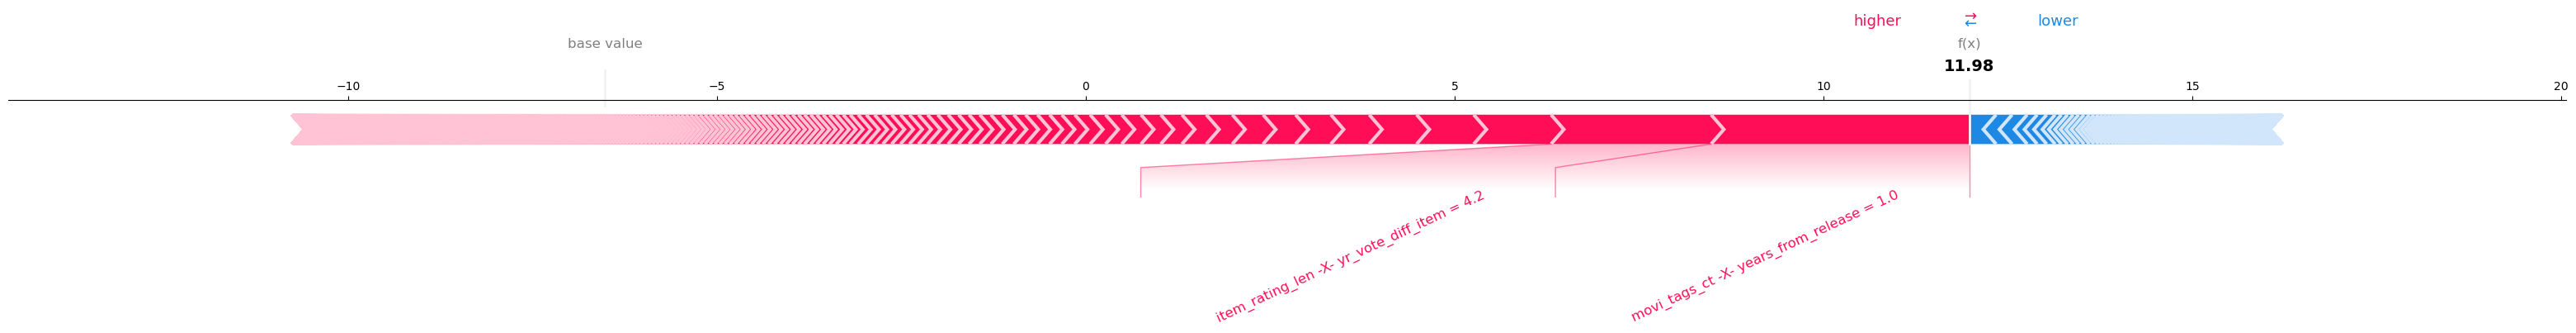

,Documentary_user_genre_rating_diff,Mystery_user_genre_rating_diff,Sci-Fi_user_genre_rating_diff,Children_user_genre_rating_diff,Musical_user_genre_rating_diff,Action_user_genre_rating_diff,Crime_user_genre_rating_diff,IMAX_user_genre_rating_diff,Adventure_user_genre_rating_diff,Fantasy_user_genre_rating_diff,Comedy_user_genre_rating_diff,Drama_user_genre_rating_diff,Thriller_user_genre_rating_diff,Western_user_genre_rating_diff,Animation_user_genre_rating_diff,War_user_genre_rating_diff,Horror_user_genre_rating_diff,Romance_user_genre_rating_diff,Documentary_user_genre_dist,Mystery_user_genre_dist,Sci-Fi_user_genre_dist,Children_user_genre_dist,Musical_user_genre_dist,Action_user_genre_dist,Crime_user_genre_dist,IMAX_user_genre_dist,Adventure_user_genre_dist,Fantasy_user_genre_dist,Comedy_user_genre_dist,Drama_user_genre_dist,Thriller_user_genre_dist,Western_user_genre_dist,Animation_user_genre_dist,War_user_genre_dist,Horror_user_genre_dist,Romance_user_genre_dist,runtime_user_wt_avg,popularity_user_wt_avg,vote_count_user_wt_avg,vote_average_user_wt_avg,enc_cast_1_user_wt_avg,years_from_release_user_wt_avg,enc_primary_lang_user_wt_avg,enc_cast_0_user_wt_avg,release_date_yr_user_wt_avg,vote_count_user_std,vote_average_user_std,enc_primary_lang_user_std,runtime_user_std,popularity_user_std,enc_cast_1_user_std,years_from_release_user_std,rating_user_std,enc_cast_0_user_std,release_date_yr_user_std,Documentary_user_cum_norm,Mystery_user_cum_norm,Sci-Fi_user_cum_norm,Children_user_cum_norm,Musical_user_cum_norm,Action_user_cum_norm,Crime_user_cum_norm,IMAX_user_cum_norm,Adventure_user_cum_norm,Fantasy_user_cum_norm,Comedy_user_cum_norm,Drama_user_cum_norm,Thriller_user_cum_norm,Western_user_cum_norm,Animation_user_cum_norm,War_user_cum_norm,Horror_user_cum_norm,Romance_user_cum_norm
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
474,-0.104237,-0.149467,-0.035191,-0.141638,-0.168156,-0.222321,-0.172697,0.322841,-0.1052,-0.205789,-0.202666,-0.106312,-0.019494,-0.313104,-0.142437,-0.343692,-0.156253,-0.028079,85.549038,3.055943,1.666438,2.263674,6.609138,1.537583,2.338536,1.270201,1.891193,2.013268,3.152899,5.111512,2.158496,4.26465,1.949591,3.881413,2.279232,5.160317,112.062038,20.213871,2075.21298,7.027151,3.582664,40.88617,3.510174,3.5985,1982.53231,3475.391465,0.692268,0.10369,22.892104,17.554574,0.46203,21.370385,0.830847,0.433529,21.364037,0.021467,0.031997,0.032278,0.026373,0.028435,0.045558,0.052933,0.004187,0.056151,0.029154,0.152923,0.260226,0.075774,0.009812,0.017436,0.024466,0.019967,0.110865


High Noon (1952) 1283


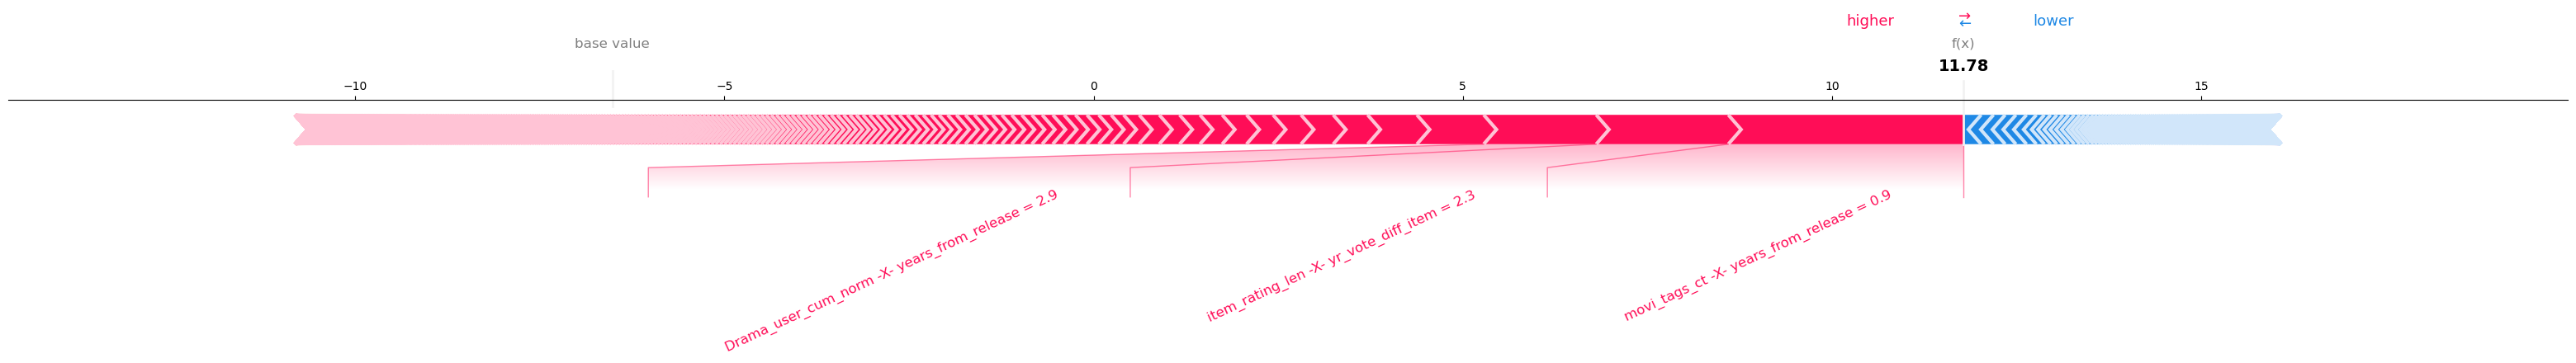

,Documentary_user_genre_rating_diff,Mystery_user_genre_rating_diff,Sci-Fi_user_genre_rating_diff,Children_user_genre_rating_diff,Musical_user_genre_rating_diff,Action_user_genre_rating_diff,Crime_user_genre_rating_diff,IMAX_user_genre_rating_diff,Adventure_user_genre_rating_diff,Fantasy_user_genre_rating_diff,Comedy_user_genre_rating_diff,Drama_user_genre_rating_diff,Thriller_user_genre_rating_diff,Western_user_genre_rating_diff,Animation_user_genre_rating_diff,War_user_genre_rating_diff,Horror_user_genre_rating_diff,Romance_user_genre_rating_diff,Documentary_user_genre_dist,Mystery_user_genre_dist,Sci-Fi_user_genre_dist,Children_user_genre_dist,Musical_user_genre_dist,Action_user_genre_dist,Crime_user_genre_dist,IMAX_user_genre_dist,Adventure_user_genre_dist,Fantasy_user_genre_dist,Comedy_user_genre_dist,Drama_user_genre_dist,Thriller_user_genre_dist,Western_user_genre_dist,Animation_user_genre_dist,War_user_genre_dist,Horror_user_genre_dist,Romance_user_genre_dist,runtime_user_wt_avg,popularity_user_wt_avg,vote_count_user_wt_avg,vote_average_user_wt_avg,enc_cast_1_user_wt_avg,years_from_release_user_wt_avg,enc_primary_lang_user_wt_avg,enc_cast_0_user_wt_avg,release_date_yr_user_wt_avg,vote_count_user_std,vote_average_user_std,enc_primary_lang_user_std,runtime_user_std,popularity_user_std,enc_cast_1_user_std,years_from_release_user_std,rating_user_std,enc_cast_0_user_std,release_date_yr_user_std,Documentary_user_cum_norm,Mystery_user_cum_norm,Sci-Fi_user_cum_norm,Children_user_cum_norm,Musical_user_cum_norm,Action_user_cum_norm,Crime_user_cum_norm,IMAX_user_cum_norm,Adventure_user_cum_norm,Fantasy_user_cum_norm,Comedy_user_cum_norm,Drama_user_cum_norm,Thriller_user_cum_norm,Western_user_cum_norm,Animation_user_cum_norm,War_user_cum_norm,Horror_user_cum_norm,Romance_user_cum_norm
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
474,-0.104237,-0.149467,-0.035191,-0.141638,-0.168156,-0.222321,-0.172697,0.322841,-0.1052,-0.205789,-0.202666,-0.106312,-0.019494,-0.313104,-0.142437,-0.343692,-0.156253,-0.028079,85.549038,3.055943,1.666438,2.263674,6.609138,1.537583,2.338536,1.270201,1.891193,2.013268,3.152899,5.111512,2.158496,4.26465,1.949591,3.881413,2.279232,5.160317,112.062038,20.213871,2075.21298,7.027151,3.582664,40.88617,3.510174,3.5985,1982.53231,3475.391465,0.692268,0.10369,22.892104,17.554574,0.46203,21.370385,0.830847,0.433529,21.364037,0.021467,0.031997,0.032278,0.026373,0.028435,0.045558,0.052933,0.004187,0.056151,0.029154,0.152923,0.260226,0.075774,0.009812,0.017436,0.024466,0.019967,0.110865


Casablanca (1942) 912


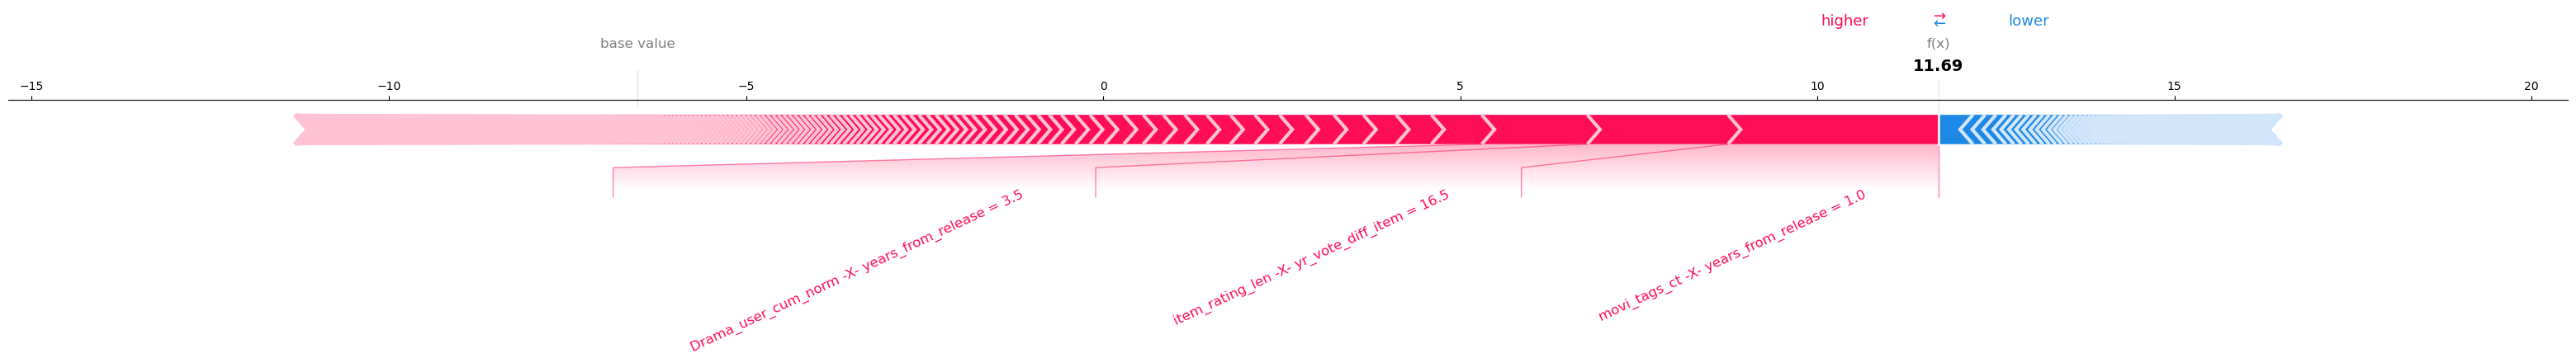

,Documentary_user_genre_rating_diff,Mystery_user_genre_rating_diff,Sci-Fi_user_genre_rating_diff,Children_user_genre_rating_diff,Musical_user_genre_rating_diff,Action_user_genre_rating_diff,Crime_user_genre_rating_diff,IMAX_user_genre_rating_diff,Adventure_user_genre_rating_diff,Fantasy_user_genre_rating_diff,Comedy_user_genre_rating_diff,Drama_user_genre_rating_diff,Thriller_user_genre_rating_diff,Western_user_genre_rating_diff,Animation_user_genre_rating_diff,War_user_genre_rating_diff,Horror_user_genre_rating_diff,Romance_user_genre_rating_diff,Documentary_user_genre_dist,Mystery_user_genre_dist,Sci-Fi_user_genre_dist,Children_user_genre_dist,Musical_user_genre_dist,Action_user_genre_dist,Crime_user_genre_dist,IMAX_user_genre_dist,Adventure_user_genre_dist,Fantasy_user_genre_dist,Comedy_user_genre_dist,Drama_user_genre_dist,Thriller_user_genre_dist,Western_user_genre_dist,Animation_user_genre_dist,War_user_genre_dist,Horror_user_genre_dist,Romance_user_genre_dist,runtime_user_wt_avg,popularity_user_wt_avg,vote_count_user_wt_avg,vote_average_user_wt_avg,enc_cast_1_user_wt_avg,years_from_release_user_wt_avg,enc_primary_lang_user_wt_avg,enc_cast_0_user_wt_avg,release_date_yr_user_wt_avg,vote_count_user_std,vote_average_user_std,enc_primary_lang_user_std,runtime_user_std,popularity_user_std,enc_cast_1_user_std,years_from_release_user_std,rating_user_std,enc_cast_0_user_std,release_date_yr_user_std,Documentary_user_cum_norm,Mystery_user_cum_norm,Sci-Fi_user_cum_norm,Children_user_cum_norm,Musical_user_cum_norm,Action_user_cum_norm,Crime_user_cum_norm,IMAX_user_cum_norm,Adventure_user_cum_norm,Fantasy_user_cum_norm,Comedy_user_cum_norm,Drama_user_cum_norm,Thriller_user_cum_norm,Western_user_cum_norm,Animation_user_cum_norm,War_user_cum_norm,Horror_user_cum_norm,Romance_user_cum_norm
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
474,-0.104237,-0.149467,-0.035191,-0.141638,-0.168156,-0.222321,-0.172697,0.322841,-0.1052,-0.205789,-0.202666,-0.106312,-0.019494,-0.313104,-0.142437,-0.343692,-0.156253,-0.028079,85.549038,3.055943,1.666438,2.263674,6.609138,1.537583,2.338536,1.270201,1.891193,2.013268,3.152899,5.111512,2.158496,4.26465,1.949591,3.881413,2.279232,5.160317,112.062038,20.213871,2075.21298,7.027151,3.582664,40.88617,3.510174,3.5985,1982.53231,3475.391465,0.692268,0.10369,22.892104,17.554574,0.46203,21.370385,0.830847,0.433529,21.364037,0.021467,0.031997,0.032278,0.026373,0.028435,0.045558,0.052933,0.004187,0.056151,0.029154,0.152923,0.260226,0.075774,0.009812,0.017436,0.024466,0.019967,0.110865


Edward Scissorhands (1990) 2291


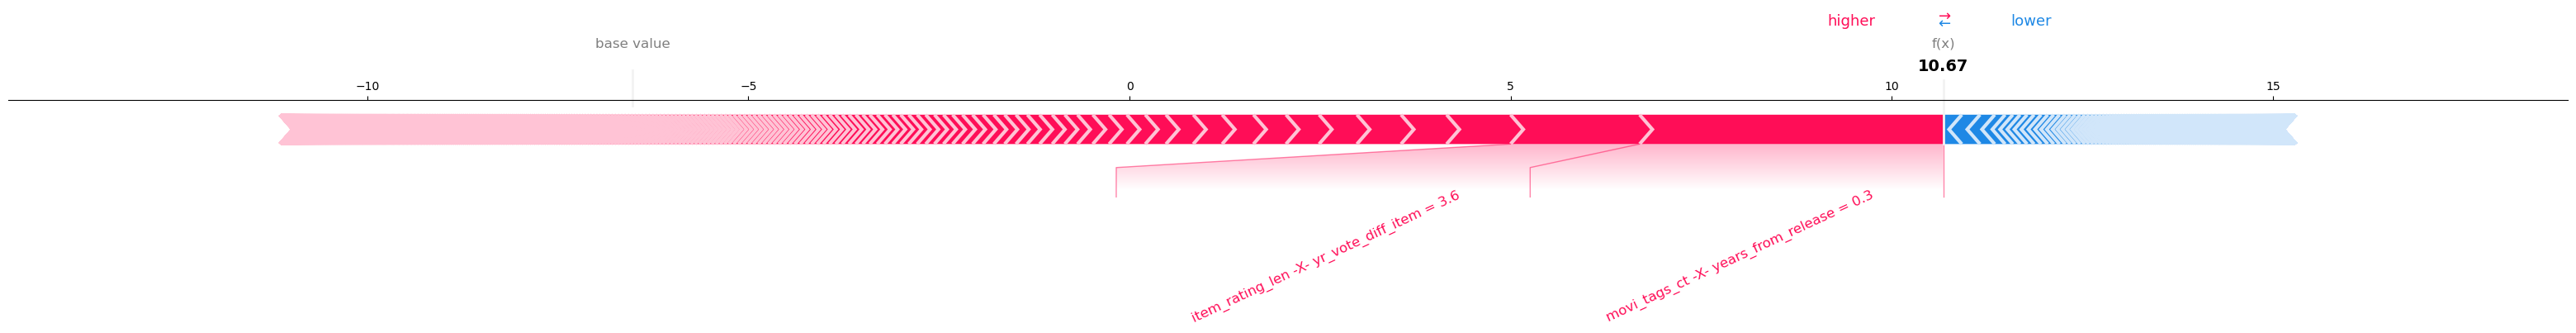

In [645]:
shap.initjs()
movie_preds = rec_user_display.drop('movieId',1).merge(_rating_y_test.loc[uid, ['has_rated']], on= 'movieId', how = 'left')[['has_rated', 'pred']]
for r in range(5):
    # r = 4
    movie = rec_user_display.iloc[r, :]
    display(_user_gen_feat.loc[[uid]])
    # display(item_df.loc[[movie.movieId]])
    print(movie.title, movie['movieId'])
    # plt.figure(figsize=(40,6))
    shap.force_plot(explainer.expected_value[1], shap_values[1][r, :], movie[feat_cols_poly],feature_names = pd.Index(feat_cols_poly).str.replace(' ', ' -X- '), matplotlib=matplotlib
                    , text_rotation=25, figsize=[40,3], contribution_threshold=0.05)